In [1]:
import torch
import torchvision
from matplotlib import pyplot as plt
from unet import MyTinyUNet
from utils import generate_image, show_images, train

from ddpm.ddpm import DDPM

In [2]:
device = None

try:
    import torch_directml
    device = torch_directml.device()
except ModuleNotFoundError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
device

device(type='privateuseone', index=0)

In [3]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(32),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5), (0.5))
    ])
dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=2048, shuffle=True, num_workers=10)

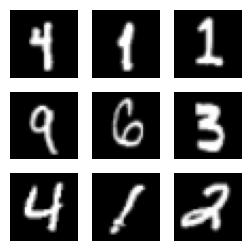

In [4]:
for b in dataloader:
    show_images(b[0][0:10])
    break

In [5]:
unet = MyTinyUNet().to(device)
model = DDPM(device, unet).to(device)

/home/chickencurry/ddpm/ddpm.py:25: UserWarning: The operator 'aten::cumprod.out' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /__w/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/dml_cpu_fallback.cpp:15.)
  self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)


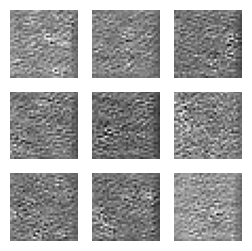

In [6]:
bs = 9
x = torch.randn(9,1,32,32).to(device)
n_steps=1000
timesteps = torch.randint(0, n_steps, (bs,)).to(device)
y = unet(x,timesteps).detach().cpu()
y.shape
show_images([n for n in y])

In [7]:
y = model.add_noise(x,x,timesteps)
y.shape

torch.Size([9, 1, 32, 32])

In [8]:
y = model.step(x,timesteps[0],x)
y.shape

torch.Size([9, 1, 32, 32])

In [ ]:
model.load_state_dict(torch.load("model.pth"))

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = train(device, model, dataloader, optimizer, num_epochs=20, num_timesteps=1000)

Epoch 19: 100%|██████████| 30/30 [00:23<00:00,  1.26it/s, loss=0.0258, step=599]


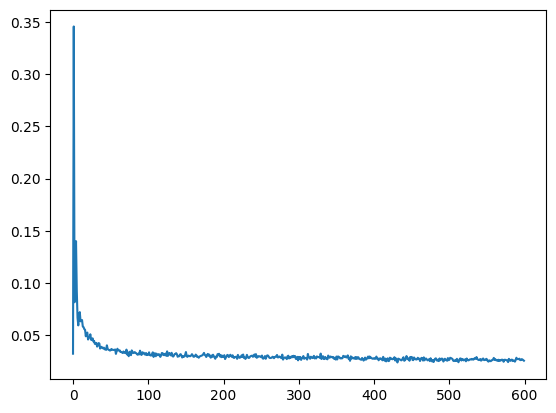

In [11]:
plt.plot(losses)
plt.show()

In [14]:
torch.save(model.state_dict(), "model.pth")

100%|██████████| 1000/1000 [00:08<00:00, 113.10it/s]


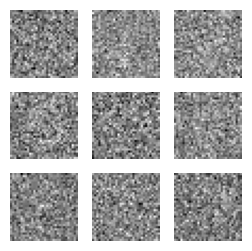

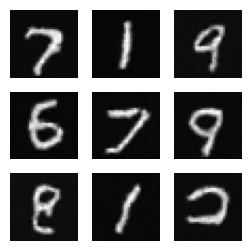

In [13]:
generated, generated_mid = generate_image(model, device, 9, 1, 32)
show_images(generated_mid)
show_images(generated)